Using device: cuda
Shape del validation set: (108063, 37)
y_true mean: 1.1158402469889894
y_pred mean: 0.13421038


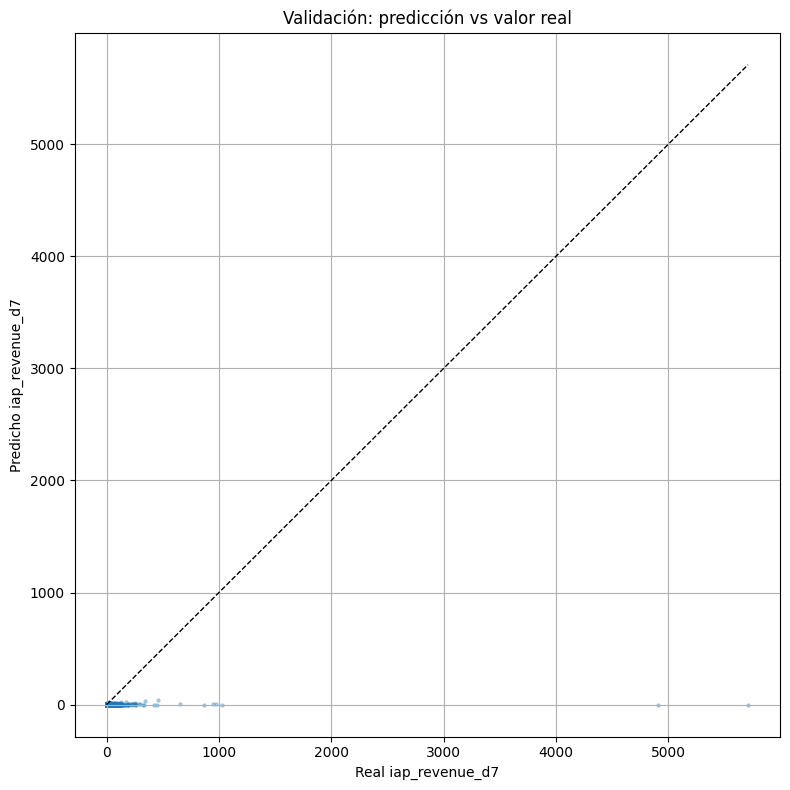

In [3]:
# %% imports básicos
import os
import json
import numpy as np
import pandas as pd
import dask.dataframe as dd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import joblib
from typing import List, Dict
from sklearn.preprocessing import StandardScaler

# %% paths y config (ajusta a tu setup)
DATASET_PATH = "./data/train"
CHECKPOINT_PATH = "model_finetuned_train_val.pth"   # <-- pon aquí tu checkpoint final

EMBEDDINGS_MAPPING_FILE = "embeddings_mappings.json"
SCALER_FILE = "scaler.joblib"

CATEGORICAL_FEATURES = ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'country', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'release_date']
NUMERICAL_FEATURES = ['release_msrp', 'weekday', 'avg_act_days', 'weekend_ratio', 'weeks_since_first_seen', 'wifi_ratio', 'hours_since_last_buy', 'hours_since_last_ins', 'hour_sin', 'hour_cos', 'first_request_ts_bundle_hours_ago', 'last_buy_ts_bundle_hours_ago', 'last_buy_ts_category_hours_ago', 'user_actions_bundles_action_last_timestamp_hours_ago', 'iap_revenue_usd_bundle_agg', 'num_buys_bundle_agg', 'rev_by_adv_agg', 'rwd_prank_agg', 'whale_users_bundle_num_buys_prank_agg', 'whale_users_bundle_revenue_prank_agg', 'whale_users_bundle_total_num_buys_agg', 'whale_users_bundle_total_revenue_agg', 'avg_daily_sessions_agg', 'avg_duration_agg', 'bcat_bottom_taxonomy_agg', 'ctr_agg', 'bundles_cat_bottom_taxonomy_agg']
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERICAL_FEATURES + [f"{col}_is_missing" for col in NUMERICAL_FEATURES]

TARGET = "iap_revenue_d7"
TARGET_BIN = "buy_d7_binary"        # 0/1 compra
TARGET_LOG = "iap_revenue_d7_log"  

def load_embeddings_mapping():
	with open(EMBEDDINGS_MAPPING_FILE, "r") as f:
		mappings = json.load(f)
	return mappings

EMBEDDING_MAPPINGS = load_embeddings_mapping()
COLS_TO_READ = [
			 'iap_revenue_d7', 
			 'advertiser_bundle', 
			 'advertiser_category', 
			 'advertiser_subcategory', 
			 'advertiser_bottom_taxonomy_level', 
			 'country', 
			 'dev_make', 
			 'dev_model', 
			 'dev_os', 
			 'dev_osv', 
			 'hour', 
			 'release_date', 
			 'release_msrp', 
			 'weekday', 
			 'avg_act_days', 
			 'avg_daily_sessions', 
			 'avg_duration', 
			 'bcat_bottom_taxonomy', 
			 'bundles_cat_bottom_taxonomy',  
			 'ctr',  
			 'first_request_ts_bundle', 
			 'iap_revenue_usd_bundle', 
			 'last_buy', 
			 'last_buy_ts_bundle', 
			 'last_buy_ts_category', 
			 'last_ins', 
			 'user_actions_bundles_action_last_timestamp', 
			 'num_buys_bundle', 
			 'rev_by_adv', 
			 'rwd_prank', 
			 'weekend_ratio', 
			 'weeks_since_first_seen', 
			 'wifi_ratio', 
			 'whale_users_bundle_num_buys_prank', 
			 'whale_users_bundle_revenue_prank', 
			 'whale_users_bundle_total_num_buys', 
			 'whale_users_bundle_total_revenue']

loaded_scaler = joblib.load(SCALER_FILE)


def process_partition(df):
	df = transform_variables(df)
	df = scale_numerical_features(df, loaded_scaler)
	df = impute_missings(df)
	return df

def hours_since_now_from_list(tuples_list, now_ts):
	# Check if the input is a list
	if isinstance(tuples_list, list) and len(tuples_list) > 0:
		# Extract all numeric timestamps from the tuples
		timestamps = []
		for t in tuples_list:
			if isinstance(t, tuple) and len(t) == 2:
				ts = t[1]
				if ts is not None and not isinstance(ts, list):
					timestamps.append(ts)
		if len(timestamps) > 0:
			# Use the largest timestamp (closest to now)
			max_ts = max(timestamps)
			return (now_ts - max_ts) / 3600  # seconds → hours
	return np.nan

def extract_numbers(tuple_list):
	"""Extract only the numeric part from a list of (id, value) tuples."""
	if isinstance(tuple_list, list):
		return [t[1] for t in tuple_list if isinstance(t, tuple) and len(t) >= 2]
	return []

def aggregate(values, mode):
	"""Apply either sum or mean depending on mode."""
	if not values:
		return np.nan
	if mode == "sum":
		return sum(values)
	return sum(values) / len(values)

def transform_variables(df):
	 
	try:

			now = pd.Timestamp.now()
			# Define reasonable bounds for Unix timestamps (seconds)
			min_ts = 0                  # 1970-01-01
			max_ts = 4102444800         # 2100-01-01 in Unix seconds

			# Replace invalid timestamps with NaN
			df["last_buy_safe"] = df["last_buy"].where(
				df["last_buy"].between(min_ts, max_ts), np.nan
			)
			df["last_ins_safe"] = df["last_ins"].where(
				df["last_ins"].between(min_ts, max_ts), np.nan
			)

			# Convert safe Unix timestamps to datetime
			df["last_buy_dt"] = pd.to_datetime(df["last_buy_safe"], unit="s")
			df["last_ins_dt"] = pd.to_datetime(df["last_ins_safe"], unit="s")

			# Compute hours ago
			df["hours_since_last_buy"] = (now - df["last_buy_dt"]).dt.total_seconds() / 3600
			df["hours_since_last_ins"] = (now - df["last_ins_dt"]).dt.total_seconds() / 3600

			# Drop the original Unix timestamp columns
			df = df.drop(columns=["last_buy", "last_ins", "last_buy_safe", "last_ins_dt", "last_buy_dt", "last_ins_safe"])




			# Convert 'hour' from string to integer
			df['hour'] = df['hour'].astype(int)

			# Convert hour to radians (full circle = 24 hours)
			radians = df['hour'] * (2 * np.pi / 24)

			# Create two new columns: sin_hour and cos_hour
			df['hour_sin'] = np.sin(radians)
			df['hour_cos'] = np.cos(radians)

			# Drop the original 'hour' column
			df.drop(columns=['hour'], inplace=True)




			# Ensure `now_ts` is a Unix timestamp
			now_ts = int(pd.Timestamp.now().timestamp())

			# Apply to your 4 timestamp columns
			ts_cols = [
				"first_request_ts_bundle",
				"last_buy_ts_bundle",
				"last_buy_ts_category",
				"user_actions_bundles_action_last_timestamp"
			]

			for col in ts_cols:
				new_col = col + "_hours_ago"
				df[new_col] = df[col].apply(lambda x: hours_since_now_from_list(x, now_ts))

			# Drop the original tuple columns if you want
			df.drop(columns=ts_cols, inplace=True)




			rules = {
				"iap_revenue_usd_bundle": "sum",
				"num_buys_bundle": "sum",
				"rev_by_adv": "sum",
				"rwd_prank": "mean",
				"whale_users_bundle_num_buys_prank": "mean",
				"whale_users_bundle_revenue_prank": "mean",
				"whale_users_bundle_total_num_buys": "sum",
				"whale_users_bundle_total_revenue": "sum",
				"avg_daily_sessions": "mean",
				"avg_duration": "mean",
				"bcat_bottom_taxonomy": "mean",
				"ctr": "sum",
				"bundles_cat_bottom_taxonomy": "sum",
			}

			for col, mode in rules.items():
				new_col = col + "_agg"
				df[new_col] = df[col].apply(
					lambda lst: aggregate(extract_numbers(lst), mode)
				)

			df.drop(columns=list(rules.keys()), inplace=True)

			# If the df contains the target column, transform it with the logarithm
			if TARGET in df.columns:
				# 1) binario de compra
				df[TARGET_BIN] = (df[TARGET] > 0).astype(float)

				# 2) log1p del importe (clip por si acaso)
				df[TARGET_LOG] = np.log1p(df[TARGET].clip(lower=0))

	# Remove all the variables and create the new ones by setting them to the default values
	except Exception:
		# If something failed, remove any partially created/intermediate columns
		ts_cols = [
			"first_request_ts_bundle",
			"last_buy_ts_bundle",
			"last_buy_ts_category",
			"user_actions_bundles_action_last_timestamp",
		]

		rules_keys = [
			"iap_revenue_usd_bundle",
			"num_buys_bundle",
			"rev_by_adv",
			"rwd_prank",
			"whale_users_bundle_num_buys_prank",
			"whale_users_bundle_revenue_prank",
			"whale_users_bundle_total_num_buys",
			"whale_users_bundle_total_revenue",
			"avg_daily_sessions",
			"avg_duration",
			"bcat_bottom_taxonomy",
			"ctr",
			"bundles_cat_bottom_taxonomy",
		]

		intermediate_cols = (
			[
				"last_buy",
				"last_ins",
				"last_buy_safe",
				"last_ins_safe",
				"last_buy_dt",
				"last_ins_dt",
				"hour",
				"hours_since_last_buy",
				"hours_since_last_ins",
				"hour_sin",
				"hour_cos",
			]
			+ [c + "_hours_ago" for c in ts_cols]
			+ [k + "_agg" for k in rules_keys]
		)

		# Drop any of those columns if they exist (silent if not)
		df.drop(columns=[c for c in intermediate_cols if c in df.columns], inplace=True, errors="ignore")

		# Create all expected features with default (NaN) values so subsequent steps won't fail
		for col in ALL_FEATURES:
			if col not in df.columns:
				df[col] = np.nan

		# Ensure target exists (set to NaN)
		if TARGET not in df.columns:
			df[TARGET] = np.nan

		# NUEVO: asegurarnos de que también existen los targets derivados
		if TARGET_BIN not in df.columns:
			df[TARGET_BIN] = np.nan

		if TARGET_LOG not in df.columns:
			df[TARGET_LOG] = np.nan

	
	return df

def impute_missings(df):

	for col in CATEGORICAL_FEATURES:
		df[col] = df[col].fillna("<MISSING>")

		# convert to embeddings indices (if category not seen before, assign index 0)
		mapping = EMBEDDING_MAPPINGS[col]
		df[col] = df[col].map(lambda x: mapping.get(x, 0))

	for col in NUMERICAL_FEATURES:
		# 1. Create missing indicator
		df[f"{col}_is_missing"] = df[col].isna().astype(float)

		# 2. Impute missings with 0
		df[col] = df[col].fillna(0).astype(float)

	return df

def scale_numerical_features(df, scaler):
	df[NUMERICAL_FEATURES] = scaler.transform(df[NUMERICAL_FEATURES])
	return df

def train_scaler(df):
	scaler = StandardScaler()
	scaler.fit(df[NUMERICAL_FEATURES])
	joblib.dump(scaler, SCALER_FILE)
	print("Scaler saved.")

def generate_embeddings_mapping(pdf):
	# Use after transform_variables but BEFORE imputing missings
	
	mappings = {}
	for feature in CATEGORICAL_FEATURES:
		unique_values = ["<MISSING>"] + pdf[feature].dropna().unique().tolist()
		embeddings = {val: idx for idx, val in enumerate(unique_values)}
		mappings[feature] = embeddings
	
	# Save mappings to disk
	with open(EMBEDDINGS_MAPPING_FILE, "w") as f:
		json.dump(mappings, f)


cat_cardinalities = {
    feat: len(EMBEDDING_MAPPINGS[feat])
    for feat in CATEGORICAL_FEATURES
}

class DeepEmbeddingMLP(nn.Module):
    def __init__(
        self,
        cat_cardinalities: Dict[str, int],
        cat_features: List[str],
        num_cont_features: int,          # numéricas + _is_missing
        embedding_dim: int = 64,
        hidden_dims: List[int] = [512, 256, 128, 64],
        dropout: float = 0.2,
    ):
        """
        cat_cardinalities: dict {feature_name: vocab_size}
        cat_features: lista de nombres de features categóricas en el MISMO orden
                      que en las columnas categóricas del input x
        num_cont_features: número total de features continuas
                           (numéricas + indicadores de missing)
        """
        super().__init__()
        self.cat_features = cat_features
        self.num_cat = len(cat_features)
        self.num_cont_features = num_cont_features
        self.embedding_dim = embedding_dim

        # Embeddings por feature categórica
        self.embeddings = nn.ModuleDict({
            feat: nn.Embedding(
                num_embeddings=cat_cardinalities[feat],
                embedding_dim=embedding_dim,
            )
            for feat in cat_features
        })

        # Dimensión de entrada al MLP: concat(numéricas, embeddings_flat)
        total_cat_dim = embedding_dim * self.num_cat
        input_dim = total_cat_dim + self.num_cont_features

        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        # Salida escalar (logit para clasificación o valor para regresión)
        layers.append(nn.Linear(prev_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [batch, num_cat + num_cont_features]
        columnas en el orden:
        [CATEGORICAL_FEATURES..., NUMERICAL_FEATURES..., NUMERICAL_IS_MISSING...]
        """
        # Separar parte categórica y continua
        x_cat_ids = x[:, :self.num_cat].long()   # [B, num_cat]
        x_cont = x[:, self.num_cat:].float()     # [B, num_cont]

        # Embeddings categóricas
        emb_list = []
        for i, feat in enumerate(self.cat_features):
            emb = self.embeddings[feat](x_cat_ids[:, i])  # [B, embedding_dim]
            emb_list.append(emb)

        if emb_list:
            x_cat_emb = torch.cat(emb_list, dim=1)        # [B, emb_dim * num_cat]
            x_in = torch.cat([x_cont, x_cat_emb], dim=1)  # [B, input_dim]
        else:
            x_in = x_cont

        out = self.mlp(x_in)          # [B, 1]
        return out.squeeze(-1)        # [B]
# %% aquí deberías importar tu pipeline real:
# from tu_modulo import process_partition, DeepEmbeddingMLP  (o EmbeddingMLP/FTTransformer)
#
# Para que el ejemplo sea autocontenido, asumo que process_partition y el modelo
# ya los tienes definidos igual que en el notebook de entrenamiento.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# %% helper para construir el tensor de features en el mismo orden que en train
def make_features_tensor(pdf: pd.DataFrame) -> torch.Tensor:
    return torch.tensor(
        pdf[
            CATEGORICAL_FEATURES
            + NUMERICAL_FEATURES
            + [f"{col}_is_missing" for col in NUMERICAL_FEATURES]
        ].values,
        dtype=torch.float32,
    )

# %% cargar validación (mismos filtros que en entrenamiento)
val_filters = [("datetime", ">=", "2025-10-06-23-00")]

ddf_val = dd.read_parquet(
    DATASET_PATH,
    engine="pyarrow",
    columns=COLS_TO_READ,   # usa la misma COLS_TO_READ del train
    filters=val_filters,
)

val_pdf = ddf_val.compute()
print(f"Shape del validation set: {val_pdf.shape}")

val_pdf = process_partition(val_pdf)

# y_true en escala original
y_true = val_pdf[TARGET].values.copy()

# si en el pipeline transformaste TARGET a log1p, asegúrate de que aquí
# estás usando la columna original sin log; si no la preservaste, mala decisión,
# pero entonces simplemente evalúas en escala log.

X_val = make_features_tensor(val_pdf)

val_dataset = TensorDataset(X_val, torch.tensor(y_true, dtype=torch.float32))
val_loader = DataLoader(
    val_dataset,
    batch_size=4096,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# %% reconstruir el modelo y cargar el checkpoint
# usa la MISMA arquitectura y parámetros que en entrenamiento
num_cont_features = len(NUMERICAL_FEATURES) * 2

with open(EMBEDDINGS_MAPPING_FILE, "r") as f:
    EMBEDDING_MAPPINGS = json.load(f)

cat_cardinalities = {
    feat: len(EMBEDDING_MAPPINGS[feat])
    for feat in CATEGORICAL_FEATURES
}

model = DeepEmbeddingMLP(
    cat_cardinalities=cat_cardinalities,
    cat_features=CATEGORICAL_FEATURES,
    num_cont_features=num_cont_features,
    embedding_dim=64,              # igual que cuando entrenaste
    hidden_dims=[512, 256, 128, 64],
    dropout=0.2,
).to(device)

state = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# %% obtener predicciones en validación
all_preds = []

with torch.no_grad():
    for (data, y_batch) in val_loader:
        data = data.to(device, non_blocking=True)

        pred = model(data)    # [batch], normalmente en log1p
        all_preds.append(pred.cpu())

y_pred = torch.cat(all_preds).numpy()

# si el modelo predice en log1p, deshaz la transformación para comparar en escala real
if TARGET_LOG:
    y_pred_real = np.expm1(y_pred)
else:
    y_pred_real = y_pred

# alineamos por si acaso
y_true = y_true[: len(y_pred_real)]

print("y_true mean:", y_true.mean())
print("y_pred mean:", y_pred_real.mean())

# %% gráfico: y_pred vs y_true

# para que el gráfico no sea un borrón, muestramos si hay demasiados puntos
max_points = 50000
n = len(y_true)
if n > max_points:
    idx = np.random.choice(n, size=max_points, replace=False)
    y_true_plot = y_true[idx]
    y_pred_plot = y_pred_real[idx]
else:
    y_true_plot = y_true
    y_pred_plot = y_pred_real

plt.figure(figsize=(8, 8))

# scatter denso
plt.scatter(y_true_plot, y_pred_plot, alpha=0.3, s=5)

# línea ideal y = x
min_val = min(y_true_plot.min(), y_pred_plot.min())
max_val = max(y_true_plot.max(), y_pred_plot.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)

plt.xlabel("Real iap_revenue_d7")
plt.ylabel("Predicho iap_revenue_d7")
plt.title("Validación: predicción vs valor real")
plt.grid(True)
plt.tight_layout()
plt.show()


Global y_true mean: 1.1158402469889894
Global y_pred mean: 0.13421012

--- GLOBAL ---
RMSE: 39.889593886094204
MAE : 1.1660285471116614

--- BUYERS (TARGET > 0) ---
n_buyers: 4280
RMSE_buyers: 200.42957381364167
MAE_buyers : 27.13333665017962
mean_true_buyers: 28.173141264105418
mean_pred_buyers: 1.0816089

--- NON-BUYERS (TARGET = 0) ---
n_nonbuyers: 103783
RMSE_nonbuyers: 0.3318898939606179
MAE_nonbuyers : 0.09513949320947267
mean_true_nonbuyers: 0.0
mean_pred_nonbuyers: 0.0951395


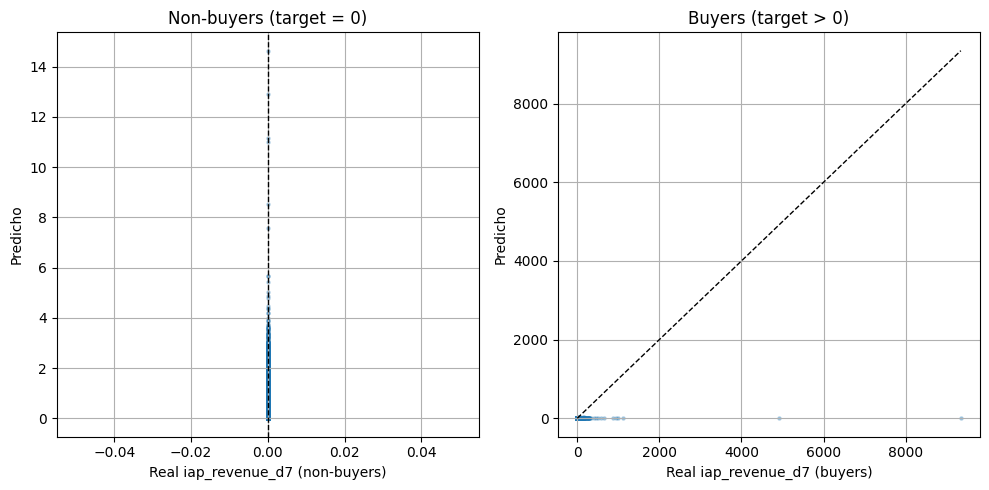

In [2]:
TARGET_LOGGED = True  # el modelo predice log1p(iap_revenue_d7)

all_preds = []

model.eval()
with torch.no_grad():
    for (data, y_batch) in val_loader:
        data = data.to(device, non_blocking=True)
        pred = model(data)    # [batch], en log1p si TARGET_LOGGED=True
        all_preds.append(pred.cpu())

y_pred = torch.cat(all_preds).numpy()

if TARGET_LOGGED:
    y_pred_real = np.expm1(y_pred)
else:
    y_pred_real = y_pred

# alineamos por si acaso
y_true = y_true[: len(y_pred_real)]

print("Global y_true mean:", y_true.mean())
print("Global y_pred mean:", y_pred_real.mean())

# ---------------------
# SPLIT POR BUYER / NON-BUYER
# ---------------------
# usamos la columna binaria que ya creas en transform_variables
buyer_flag = val_pdf[TARGET_BIN].values[: len(y_pred_real)]  # 0/1
is_buyer = buyer_flag == 1
is_nonbuyer = ~is_buyer

y_true_buyers = y_true[is_buyer]
y_pred_buyers = y_pred_real[is_buyer]

y_true_nonbuyers = y_true[is_nonbuyer]
y_pred_nonbuyers = y_pred_real[is_nonbuyer]

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat) ** 2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

print("\n--- GLOBAL ---")
print("RMSE:", rmse(y_true, y_pred_real))
print("MAE :", mae(y_true, y_pred_real))

print("\n--- BUYERS (TARGET > 0) ---")
print("n_buyers:", len(y_true_buyers))
print("RMSE_buyers:", rmse(y_true_buyers, y_pred_buyers))
print("MAE_buyers :", mae(y_true_buyers, y_pred_buyers))
print("mean_true_buyers:", y_true_buyers.mean())
print("mean_pred_buyers:", y_pred_buyers.mean())

print("\n--- NON-BUYERS (TARGET = 0) ---")
print("n_nonbuyers:", len(y_true_nonbuyers))
print("RMSE_nonbuyers:", rmse(y_true_nonbuyers, y_pred_nonbuyers))
print("MAE_nonbuyers :", mae(y_true_nonbuyers, y_pred_nonbuyers))
print("mean_true_nonbuyers:", y_true_nonbuyers.mean())
print("mean_pred_nonbuyers:", y_pred_nonbuyers.mean())

# ---------------------
# GRÁFICO: y_pred vs y_true POR GRUPO
# ---------------------

max_points = 50000
n = len(y_true)
if n > max_points:
    idx = np.random.choice(n, size=max_points, replace=False)
    y_true_sample = y_true[idx]
    y_pred_sample = y_pred_real[idx]
    is_buyer_sample = is_buyer[idx]
else:
    y_true_sample = y_true
    y_pred_sample = y_pred_real
    is_buyer_sample = is_buyer

plt.figure(figsize=(10, 5))

# subplot 1: NO compradores
plt.subplot(1, 2, 1)
mask_nb = ~is_buyer_sample
plt.scatter(
    y_true_sample[mask_nb],
    y_pred_sample[mask_nb],
    alpha=0.3,
    s=5,
)
# como casi todo será y_true=0, esto te da idea de cuánto "ruido" metes
plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Real iap_revenue_d7 (non-buyers)")
plt.ylabel("Predicho")
plt.title("Non-buyers (target = 0)")
plt.grid(True)

# subplot 2: compradores
plt.subplot(1, 2, 2)
mask_b = is_buyer_sample
plt.scatter(
    y_true_sample[mask_b],
    y_pred_sample[mask_b],
    alpha=0.3,
    s=5,
)
min_val = min(y_true_sample[mask_b].min(), y_pred_sample[mask_b].min())
max_val = max(y_true_sample[mask_b].max(), y_pred_sample[mask_b].max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
plt.xlabel("Real iap_revenue_d7 (buyers)")
plt.ylabel("Predicho")
plt.title("Buyers (target > 0)")
plt.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Shape del validation set: (108063, 37)
ROC AUC: 0.9218
PR  AUC: 0.3697

Confusion matrix (thr=0.5):
[[103733     50]
 [  4089    191]]

Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9621    0.9995    0.9804    103783
           1     0.7925    0.0446    0.0845      4280

    accuracy                         0.9617    108063
   macro avg     0.8773    0.5221    0.5325    108063
weighted avg     0.9554    0.9617    0.9450    108063

Base rate buyers: 0.0396
Predicted positive rate (thr=0.5): 0.0022


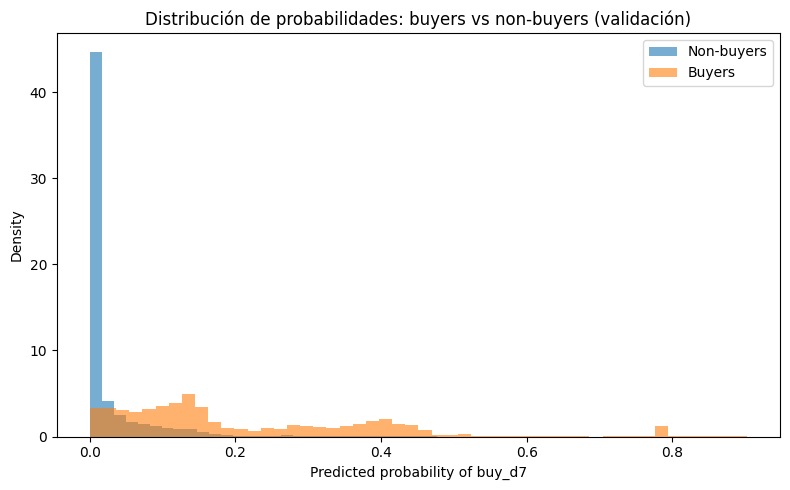

In [4]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)
import torch
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# CONFIG
# -------------------
CLASSIFIER_CHECKPOINT_PATH = "model_checkpoint_v1_f_cls_e1.pth"  # <-- pon aquí tu ckpt de clasificador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# 1) Cargar validación y preprocesar (ya lo tienes arriba)
# -------------------
val_filters = [("datetime", ">=", "2025-10-06-23-00")]

ddf_val = dd.read_parquet(
    DATASET_PATH,
    engine="pyarrow",
    columns=COLS_TO_READ,
    filters=val_filters,
)

val_pdf = ddf_val.compute()

print(f"Shape del validation set: {val_pdf.shape}")

val_pdf = process_partition(val_pdf)

# Target binario: 0/1
y_true_bin = val_pdf[TARGET_BIN].values.astype(int)

X_val = make_features_tensor(val_pdf)

val_dataset_cls = TensorDataset(
    X_val,
    torch.tensor(y_true_bin, dtype=torch.float32),
)
val_loader_cls = DataLoader(
    val_dataset_cls,
    batch_size=4096,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# -------------------
# 2) Reconstruir el modelo clasificador y cargar checkpoint
#    (misma arquitectura que en el entrenamiento del clasificador)
# -------------------
num_cont_features = len(NUMERICAL_FEATURES) * 2

with open(EMBEDDINGS_MAPPING_FILE, "r") as f:
    EMBEDDING_MAPPINGS = json.load(f)

cat_cardinalities = {
    feat: len(EMBEDDING_MAPPINGS[feat])
    for feat in CATEGORICAL_FEATURES
}

clf_model = DeepEmbeddingMLP(
    cat_cardinalities=cat_cardinalities,
    cat_features=CATEGORICAL_FEATURES,
    num_cont_features=num_cont_features,
    embedding_dim=64,              # igual que cuando entrenaste el clasificador
    hidden_dims=[512, 256, 128, 64],
    dropout=0.2,
).to(device)

cls_state = torch.load(CLASSIFIER_CHECKPOINT_PATH, map_location=device)
clf_model.load_state_dict(cls_state)
clf_model.eval()

# -------------------
# 3) Inferencia: logits -> probs
# -------------------
all_logits = []
all_targets = []

with torch.no_grad():
    for data, target in val_loader_cls:
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        logits = clf_model(data)          # [B], logits
        all_logits.append(logits.cpu())
        all_targets.append(target.cpu())

logits = torch.cat(all_logits).numpy()
y_true = torch.cat(all_targets).numpy().astype(int)
probs = 1 / (1 + np.exp(-logits))        # sigmoid

# -------------------
# 4) Métricas de clasificación
# -------------------
# ROC AUC y PR AUC (más útil con dataset desbalanceado)
roc_auc = roc_auc_score(y_true, probs)
pr_auc = average_precision_score(y_true, probs)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR  AUC: {pr_auc:.4f}")

# Threshold 0.5 por defecto
threshold = 0.5
y_pred = (probs >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix (thr=0.5):")
print(cm)

print("\nClassification report (thr=0.5):")
print(classification_report(y_true, y_pred, digits=4))

print(f"Base rate buyers: {y_true.mean():.4f}")
print(f"Predicted positive rate (thr=0.5): {y_pred.mean():.4f}")

# -------------------
# 5) Histograma de probabilidades para buyers vs non-buyers
# -------------------
buyers_mask = y_true == 1
nonbuyers_mask = ~buyers_mask

plt.figure(figsize=(8, 5))
plt.hist(
    probs[nonbuyers_mask],
    bins=50,
    alpha=0.6,
    label="Non-buyers",
    density=True,
)
plt.hist(
    probs[buyers_mask],
    bins=50,
    alpha=0.6,
    label="Buyers",
    density=True,
)
plt.xlabel("Predicted probability of buy_d7")
plt.ylabel("Density")
plt.title("Distribución de probabilidades: buyers vs non-buyers (validación)")
plt.legend()
plt.tight_layout()
plt.show()
